The time-series data we have examined in the recent sessions have had a few nice properties that make them easy to process. Unfortunately, real-world data often fails at least one of these assumptions, requiring us to pre-process it before we can extract time-domain or frequency-domain characteristics. In this notebook, we will cover some of these assumptions and discuss ways of addressing them.

# Important: Run this code cell each time you start a new session!

In [1]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


In [2]:
!wget -Ncnp https://physionet.org/files/accelerometry-walk-climb-drive/1.0.0/raw_accelerometry_data/id00b70b13.csv

--2024-06-21 03:47:31--  https://physionet.org/files/accelerometry-walk-climb-drive/1.0.0/raw_accelerometry_data/id00b70b13.csv
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25931775 (25M) [text/plain]
Saving to: ‘id00b70b13.csv’

id00b70b13.csv      100%[===================>]  24.73M   664KB/s    in 39s     

2024-06-21 03:48:10 (656 KB/s) - ‘id00b70b13.csv’ saved [25931775/25931775]



In [3]:
df = pd.read_csv('id00b70b13.csv')

# Filter to only walking activity, which is given a code of 1
df = df[df['activity'] == 1]

# Process the time
df.rename(columns={'time_s': 'Time'}, inplace=True)
df = df[(df['Time']>=700) & (df['Time']<=710)]
df['Time'] = df['Time'] - df['Time'].min()

# Process the accel
df['Accel'] = np.sqrt(df['la_x']**2 + df['la_y']**2 + df['la_z']**2)*9.8

# Keep only crucial columns
keep_cols = ['Time', 'Accel']
df = df[keep_cols]
df.to_csv('walking.csv',index=False)

<ipython-input-3-56954139a89d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'time_s': 'Time'}, inplace=True)


# What is a Digital Filter

In the context of digital signal processing, ***filtering*** refers to the process of modifying or manipulating a digital signal by altering its frequency characteristics, selectively allowing or attenuating certain frequencies while leaving others unaffected.

For example, filters can be useful in situations when you expect that the phenomenon you are trying to isolate and signal noise are located in separate frequency ranges; with sensors, it is often the case that intrinsic noise is in higher frequencies.


There are four kinds of digital filters:
1. **Low-pass filter:** This filter allows low-frequency components to pass through while attenuating high-frequency components. It is commonly used to remove noise or unwanted high-frequency signals from a signal of interest.
2. **High-pass filter:** The high-pass filter allows high-frequency components to pass through while attenuating low-frequency components. It is useful for filtering out low-frequency noise or unwanted signals and emphasizes high-frequency features in a signal.
3. **Band-pass filter:** This filter allows a specific range of frequencies, referred to as the passband, to pass through while attenuating frequencies outside this range. It is useful when you want to isolate and extract a specific frequency range from a signal, while attenuating both low and high-frequency components.
4. **Band-stop (notch) filter:** The band-stop filter attenuates a specific range of frequencies, referred to as the stopband, while allowing frequencies outside this range to pass through. It is used to eliminate or reduce interference or noise at specific frequencies without affecting the signals at other frequencies.

There are many different ways of mathematically defining and implementing a filter. One of the most popular types of filters is a ***Butterworth filter***. We don't need to be too concerned about what makes a Butterworth filter special, but we are mentioning this name since you will see it being used by name in many digital signal processing libraries.

# How to Apply a Digital Filter

The `scipy` provides useful functions for implementing and applying filters. The `butter()` function allows you to create a filter according to the following parameters:
* `N`: The ***order*** of the filter, which determines the slope of the roll-off in the stopband. Typical values are 3, 5, and 7, with higher-order filters have a steeper roll-off but a more complex implementation.
* `Wn`: The ***cutoff/critical frequencies*** of your filter, which define the boundaries where frequencies will be passed or attenuated.
* `btype`: The type of filter you want to implement (i.e., `{‘lowpass’, ‘highpass’, ‘bandpass’, ‘bandstop’}`)

You will see that the `butter()` function actually returns two parameters, `b` and `a`. These variables simply define the numerator and denominator polynomials of the filter, respectively.

Meanwhile, the `filtfilt()` function allows you to apply a filter to a signal and takes the following parameters:
* `b`: The polynomial numerators of the filter
* `a`: The polynomial denominators of the filter
* `x`: The values of the signal

Notice that we do not provide the timestamps of our data series to this function. This is because the function assumes that the signal is evenly sampled and the sampling rate of our signal is already baked into the construction of the filter.


Here are some examples of functions for generating low-pass and band-pass filters. These functions could easily be changed to high-pass and band-stop function respectively by changing the string passed to the `butter()` function.

In [4]:
from scipy.signal import butter, filtfilt

def butter_lowpass(data, fs, cutoff, order=5):
    """
    Apply a low-pass filter to time-series data
    data: the values of the time-series data (not the timestamps)
    fs: the sampling rate
    cutoff: the cutoff frequency
    order: the order of the Butterworth filter (i.e., the "sharpness" of the cutoff)
    """
    # Define the cutoff frequency in terms of the Nyquist frequency of the signal
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq

    # Compute the low-pass filter
    b, a = butter(order, normal_cutoff, btype='lowpass')

    # Apply the filter
    y = filtfilt(b, a, data)
    return y

In [5]:
from scipy.signal import butter, filtfilt

def butter_bandpass(data, fs, lower_cutoff, upper_cutoff, order=5):
    """
    Apply a band-pass filter to time-series data
    data: the values of the time-series data (not the timestamps)
    fs: the sampling rate
    lower_cutoff: the lower cutoff frequency
    upper_cutoff: the upper cutoff frequency
    order: the order of the Butterworth filter (i.e., the "sharpness" of the cutoff)
    """
    # Define the cutoff frequency in terms of the Nyquist frequency of the signal
    nyq = 0.5 * fs
    normal_lower_cutoff = lower_cutoff / nyq
    normal_upper_cutoff = upper_cutoff / nyq

    # Compute the band-pass filter
    b, a = butter(order, [normal_lower_cutoff, normal_upper_cutoff], btype='band')

    # Apply the filter
    y = filtfilt(b, a, data)
    return y

# Example with Motion Data

Now that we've covered the functions at our disposal, let's see what happens when we apply a low-pass Butterworth filter to our motion data. To show what the filter is doing in both the time and frequency domains, we are going to use our `show_fft()` function from earlier in order to view the original and filtered signals:

In [6]:
from numpy.fft import fftfreq
from scipy.fftpack import fft
def show_fft(x, y, fs=1000, time_ylim=None, fft_xlim_max=None):
    """
    Shows the time-domain signal and the corresponding FFT
    x: the timestamps of the signal
    y: the values of the signal
    fs: the sampling rate of our signal
    time_ylim: the boundaries of the y-axis for the time-domain plot
    fft_xlim_max: the right boundary for the x-axis of the FFT plot,
    indicating the highest frequency we care to view
    """
    # Compute the FFT
    fft_mag = np.abs(fft(y))
    freqs = fftfreq(len(y), 1/fs)

    # Keep the components associated with positive frequencies
    pos_freq_idxs = freqs >= 0
    freqs = freqs[pos_freq_idxs]
    fft_mag = fft_mag[pos_freq_idxs]

    # Show the signal in the time domain
    plt.figure(figsize=(12, 3))
    plt.subplot(1, 2, 1)
    plt.plot(x, y)
    plt.xlabel('Time (s)')
    plt.ylabel('Value')
    if time_ylim:
        plt.ylim(time_ylim[0], time_ylim[1])
    plt.title('Time Domain')

    # Show the signal in the frequency domain
    plt.subplot(1, 2, 2)
    plt.stem(freqs, fft_mag, markerfmt=" ", basefmt="-")
    plt.xlabel('Freq (Hz)')
    plt.ylabel('FFT Amplitude |X(freq)|')
    plt.xlim(-0.1, fft_xlim_max if fft_xlim_max else freqs.max())
    plt.title('Frequency Domain')
    plt.show()

Below, the top row of graphs will show the original signal, and the bottom row of graphs will show the filtered result. Play around with the slider below to see what happens when you change the cutoff frequency of the low-pass filter:

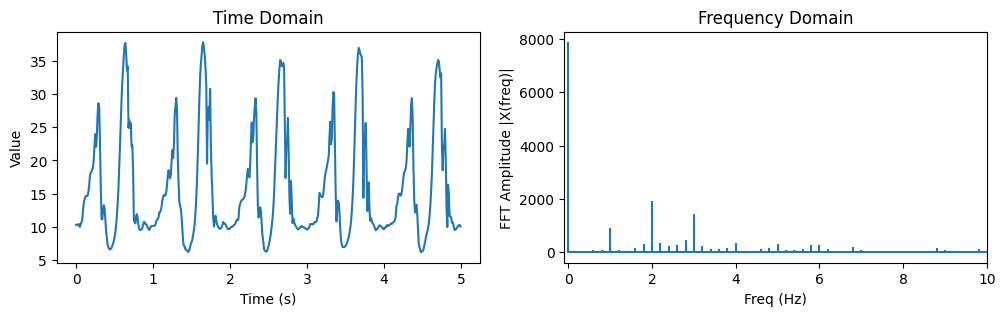

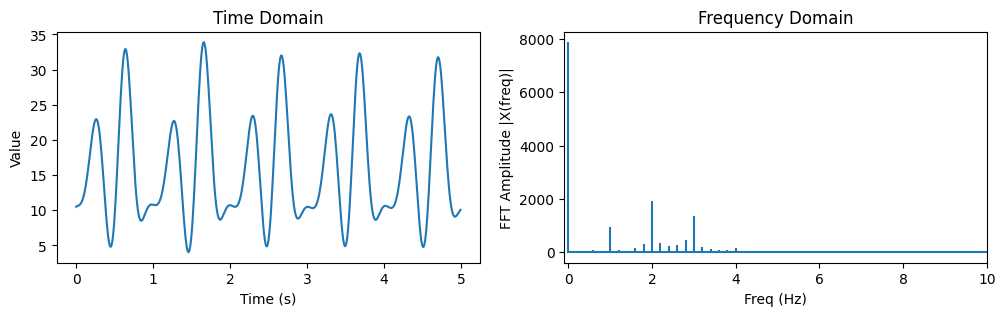

In [7]:
# Load our data and get a small chunk so it's easier to view
df = pd.read_csv('walking.csv')
df = df[df['Time'] < 5]
x = df['Time'].values
y = df['Accel'].values
fs = 100

# Apply the low-pass filter
cutoff_freq = 4 #@param {type:"slider", min:0.5, max:5, step:0.5}
y_lowpass = butter_lowpass(y, fs, cutoff=cutoff_freq)
show_fft(x, y, fs=100, fft_xlim_max=10)
show_fft(x, y_lowpass, fs=100, fft_xlim_max=10)

Here are some observations to be gathered from these examples:
* **Frequency domain:** In the original signal's FFT, we can see that there is frequency content throughout the frequency spectrum, even as high as 10 Hz. In the filter signal's FFT, however, you should see some of that frequency content disappear depending on where you set the your cutoff frequency. This shows that the low-pass filter is working as intended: attenuating higher frequencies and passing lower ones.
* **Time domain (smoothness):** Applying the low-pass filter makes are signal much smoother since the spikes were essentially higher frequency sinusoids being super-imposed on the ideal signal we were trying to capture. Smoothing the signal can make it easier to identify peaks, valleys, and trends in your data.
* **Time domain (amplitude):** As we lower the cutoff frequency, you might notice that the filtered signal in the bottom-left actually becomes shorter in amplitude. This is because some of the amplitude was coming from the higher frequencies. Therefore, filtering may not be ideal if the exact amplitude of your signal is really important.
* **Removing too much:** Notice that if we set the cutoff frequency below 1 Hz, we remove the meaningful frequency content at 2 Hz and can no longer see the 2 steps per second that we originally had in our signal. Therefore, it is important to think about the range of frequencies that you expect in your data when designing your filters.

# Summary

There are many techniques at our disposal in order to make real-world data conform to these assumptions. However, it will be important for you to consider the implications of applying these techniques to your data. If you preprocess your data too heavily, you may remove important information that will be useful down the road for other analyses.